# Task 2. Review Sentiment Classification

---

In [2]:
# importing modules
from pathlib import Path
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import (
    GridSearchCV,train_test_split,
    cross_val_score, RepeatedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay,precision_score, recall_score)    
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# nltk libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Checking and Creating directory structure if doesn't exist.

In [3]:
dir_data = Path("data")
dir_data.mkdir(parents=True, exist_ok=True)

Reading json data and converting rating variable from numerical to categorical.

In [6]:
df = pd.read_json((dir_data / "full_data.json"), orient="index")
cleanup_nums = {
    "star_rating": {
        1: "negative",
        2: "negative",
        3: "negative",
        4: "positive",
        5: "positive",
    }
}
df = df.replace(cleanup_nums)

In [7]:
df.head(2)

,year,title,metadata,star_rating,review
0,2016,The herbs were great...but the cherry tomatoes...,15 out of 17 users found this review helpful,negative,The herb kit that came with my Aerogarden was ...
1,2016,Even more useful than regular parchment paper,19 out of 19 users found this review helpful,positive,I originally bought this just because it was c...


## Step 0 : Pre-Processing

Setting upnltk stopwords and making a function expand_review which will fix the not word

In [8]:
# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand review
def expand_review(review):
	expand_review = []
	for word in review:
		if re.search("n't", word):
			expand_review.extend((word.split("n't")[0], "not"))
		else:
			expand_review.append(word)
	return expand_review

Function to clean the review text. Following are done in this function
- Step 1 : Case Conversion to lower
- Step 2: Filtering
  - Removing numbers and special characters
  - Removing urls
  - Removing single characters
- Step 3: Tokenisation
- Step 4: Filter stopwords
- expanding not word
- Step 5: Lemmatizing/Stemming
- Joining them back



In [9]:
# Function to process reviews
def Clean_review(data, wordNetLemmatizer, porterStemmer):
	data['Clean_review'] = data['review']
	# Step 1: Case Conversion
	print("Converting to lower case")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: review.lower())

	# Step 2: Filtering
	print("Removing numbers and special characters")
	data['Clean_review'] = data['Clean_review'].str.replace("[^a-zA-Z' ]","", regex=True)
	print("Removing urls")
	data['Clean_review'] = data['Clean_review'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "", regex=True)
	print("Removing single characters")
	data['Clean_review'] = data['Clean_review'].replace(re.compile(r"(^| ).( |$)"), " ", regex=True)

	# Step 3: Tokenisation
	print("Tokenising")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: nltk.word_tokenize(review))
	
	# Step 4: Filter stopwords
	print("Removing stopwords")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: [word for word in review if word not in STOPWORDS])

	# expanding not word
	print("Expanding not words")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: expand_review(review))

	# Step 5: Lemmatizing/Stemming
	print("Lemmatizing the words")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: [wordNetLemmatizer.lemmatize(word) for word in review])

	# print("Stemming the words")
	# data['Clean_review'] = data['Clean_review'].apply(lambda review: [porterStemmer.stem(word) for word in review])
	
	# Joining them back
	print("Combining words back to reviews")
	data['Clean_review'] = data['Clean_review'].apply(lambda review: ' '.join(review))
	return data

In [16]:
# Define processing methods
wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# Pre-processing the reviews
train_data = Clean_review(df, wordNetLemmatizer, porterStemmer)

Converting to lower case
Removing numbers and special characters
Removing urls
Removing single characters
Tokenising
Removing stopwords
Expanding not words
Lemmatizing the words
Combining words back to reviews


Plotting out the TOP 30 most frequent occuring keywords after CountVectorizer

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

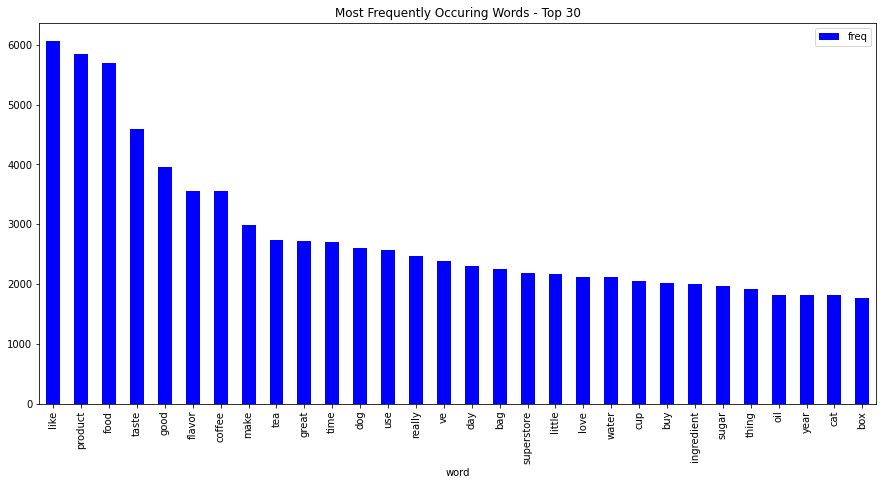

In [17]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_data.Clean_review)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Creating a WordCloud for the Vocabulary from Review

Text(0.5, 1.0, 'WordCloud - Vocabulary \n')

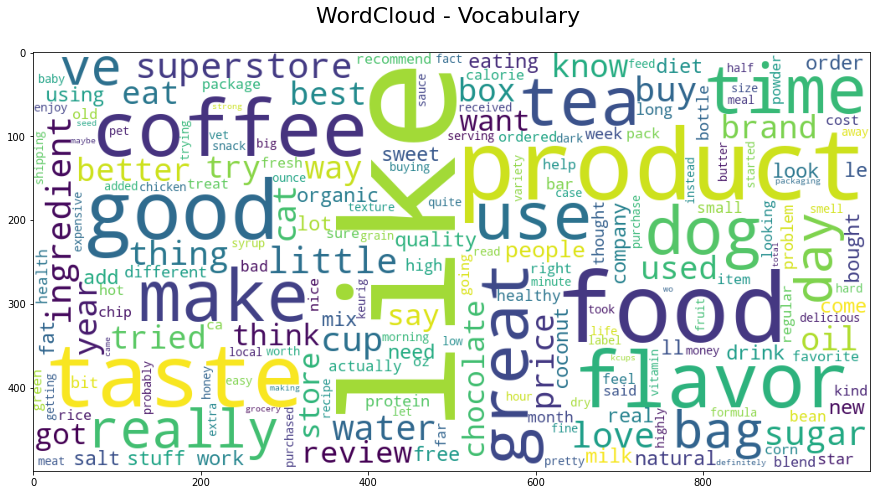

In [18]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 500).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary \n", fontsize = 22)

Creating a pie chart for the type of ratings present in df

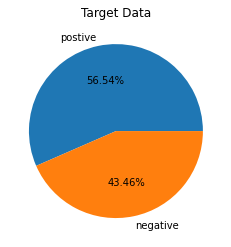

In [19]:
data = df['star_rating'].value_counts()
data.plot(kind='pie',labels=['postive','negative'],autopct='%.2f%%',ylabel='',title='Target Data')

So this is a good target set where around 56% data is positive and other 46% data is negative.

Creating a wordcloud for the positive words.

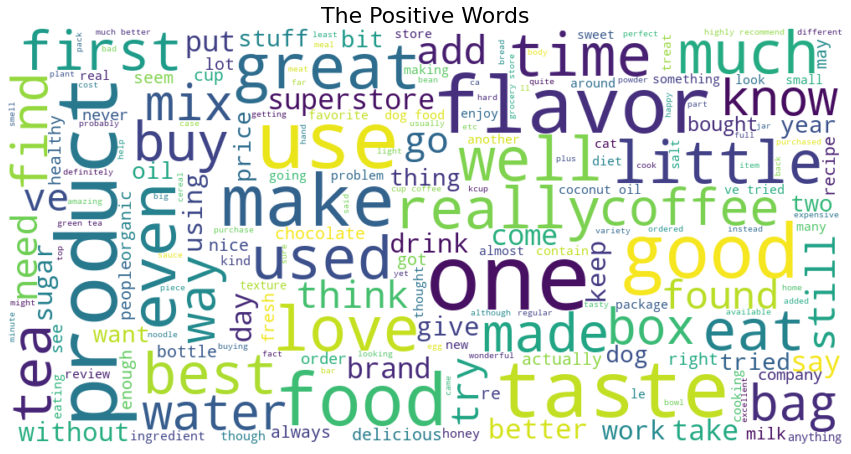

In [20]:
positive_words = ' '.join(list(train_data['Clean_review'][train_data['star_rating'] == "positive"]))

wordcloud = WordCloud(width=1000, height=500,background_color = 'white', random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words', fontsize = 22)
plt.show()

We can see that 'product','flavour','one','taste',etc. contribute to good vocabulary.

Creating a word cloud for negative words

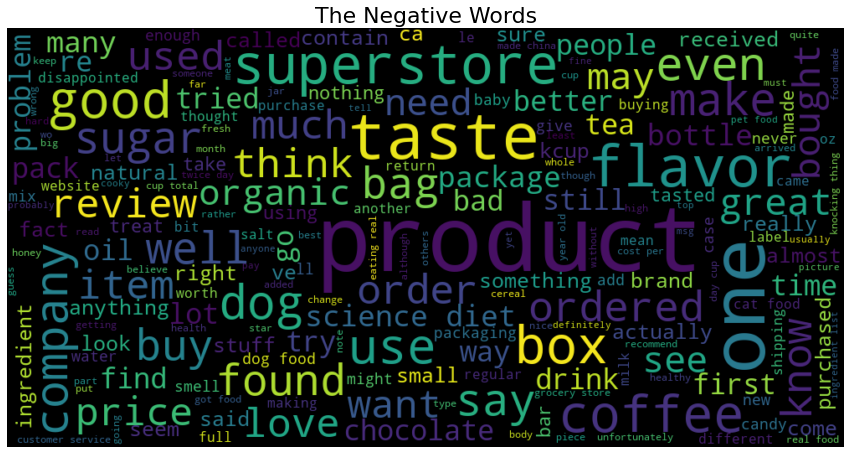

In [15]:
negative_words = ' '.join(list(train_data['Clean_review'][train_data['star_rating'] == 'negative']))

wordcloud = WordCloud(width=1000, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words' , fontsize = 22)
plt.show()

We can see that 'product','superstore','coffee',etc. contribute to a bad review.

Let's look at the first review of original vs the cleaned one.

In [18]:
df['review'][0]

'The herb kit that came with my Aerogarden was superb and I enjoyed caring for my little garden. Once it was time to replace it, I purchased the cherry tomato seed kit. These also grew rapidly, but one day I noticed that they had completely fallen over...how would I stake these on an Aerogarden? And yes, the lights were as close to the plants as possible. I kind of leaned them against each other to keep them upright. But they still fell over several times. So they grew and grew but I never got any tomatoes. :( I also did follow the directions to ensure that they had complete darkness for proper flowering. Fortunately we have several tomato and cherry tomato plants in our outdoor vegetable garden. Unfortunately, I spent $20 on 3 cherry tomato Aerogarden plants and got zero yield. …'

In [19]:
df['Clean_review'][0]

'herb kit came aerogarden superb enjoyed caring little garden time replace purchased cherry tomato seed kit also grew rapidly one day noticed completely fallen overhow would stake aerogarden yes light close plant possible kind leaned keep upright still fell several time grew grew never got tomato also follow direction ensure complete darkness proper flowering fortunately several tomato cherry tomato plant outdoor vegetable garden unfortunately spent cherry tomato aerogarden plant got zero yield'

We can notice that the filtering is done properly and lemmatization is also applied.

Let's define some variable for model training purposes.

In [20]:
# negative, positive
target_categories = ["negative", "positive"]
# Content for all documents
documents = df["Clean_review"]
# Class labels for all documents
target = df["star_rating"]

## Using KNN

We start with kNN classification.

In [21]:
vectorizer = CountVectorizer(min_df = 10, stop_words=None)
X = vectorizer.fit_transform(documents)
print(X.shape)

(9244, 5116)


After vectorization it created 5116 columns for the bag of words.

Let's split the dataset into train(80%) and test(20%) then check the size.

In [22]:
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.2)
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

Training set has 7395 examples
Test set has 1849 examples


Now we define the model and for 3 neighbours we fit the model and predict the test data.

In [23]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, target_train)
predicted = model.predict(data_test)
print("Accuracy = %.4f" % accuracy_score(target_test, predicted))

Accuracy = 0.6744


We found accuracy is 68%. This is bad model, let's look at the confusion matrix.

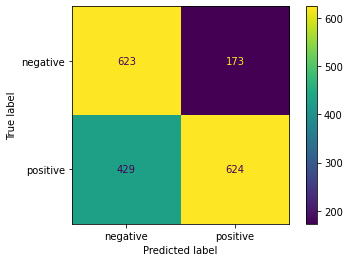

In [24]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['negative','positive'])

# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

Let's also look at the precision and recall. Also, lets print the classification report.

In [25]:
print("Precision (English) = %.4f" % precision_score(target_test, predicted, pos_label='positive') )
print("Recall (English) = %.4f" % recall_score(target_test, predicted, pos_label='positive') )
print(classification_report(target_test, predicted, target_names=target_categories))

Precision (English) = 0.7829
Recall (English) = 0.5926
              precision    recall  f1-score   support

    negative       0.59      0.78      0.67       796
    positive       0.78      0.59      0.67      1053

    accuracy                           0.67      1849
   macro avg       0.69      0.69      0.67      1849
weighted avg       0.70      0.67      0.67      1849



Okay, so we get precision as 78% and recall as 61%. Let's see if we are getting different results in k-Fold startegy.

---

Proposing 5 fold cross validation to check the model.

In [26]:
# create a single classifier
model = KNeighborsClassifier(n_neighbors=3)
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(model, X, target, cv=5, scoring="accuracy")
# represent the results as a Pandas Series
labels = ["Fold %d" % i for i in range(1,len(acc_scores)+1)]
s_acc = pd.Series(acc_scores, index = labels)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.6761


Okay so accuracy is 67%, this is bad. Let's look at repreatedKFolds with 5 splits and 10 repreats.

In [27]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
# note that we pass RepeatedKFold as the parameter cv
repeated_acc_scores = cross_val_score(model, X, target, cv=rkf, scoring="accuracy")
s_racc = pd.Series(repeated_acc_scores)
print("Overall mean accuracy: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy: 0.6809
Overall standard deviation in accuracy: 0.0129


So the accuracy just got increased by 1%. We can look at other models now in the form of pipeline.

## Pipelines

KNN Classifier

In [28]:
pipeline1 = Pipeline([
    ('vec', CountVectorizer(min_df = 10, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline1, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy (kNN): %.4f" % s_acc.mean())

Mean accuracy (kNN): 0.7250


AdaBoostClassifier

In [29]:
pipeline2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('clf', AdaBoostClassifier())
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline2, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy (AdaBoost): %.4f" % s_acc.mean())

Mean accuracy (AdaBoost): 0.7706


So, AdaBoost gave comparively better results than kNN.

Let's look at SVC and apply grid search on to it.

## SVC

In [30]:
pipeline3 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('SVM', svm.SVC())
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline3, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8600


With some parameter fix, I was 

In [32]:
pipeline3 = Pipeline([
    ('vec', CountVectorizer(stop_words="english",ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('SVM', svm.SVC(kernel='linear', C=10,gamma=0.1))
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline3, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8629


## Grid Search on SGDClassifier

In [33]:
pipeline4 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline4, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8502


In [34]:
parameters = {'vec__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'clf__penalty': ['l2'],
    'clf__n_jobs': [-1]}
grid = GridSearchCV(pipeline4, parameters, n_jobs=-1)
grid.fit(documents, target)
print("score = %3.2f" %(grid.score(documents,target)))
print(grid.best_params_)

score = 1.00
{'clf__alpha': 0.0001, 'clf__n_jobs': -1, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vec__ngram_range': (1, 2)}


In [35]:
# tuned SGDClassifier
pipeline4 = Pipeline([
    ('vec', CountVectorizer(stop_words="english",ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(alpha=0.0001, n_jobs= -1, penalty= 'l2'))
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline4, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8625


SGD was perfected to 86.25% from 85%. This is great.

## Grid Search on MultinomialNB

In [36]:
pipeline5 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB())
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline5, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.7713


In [37]:
parameters = {'vec__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3)}
grid = GridSearchCV(pipeline5, parameters, n_jobs=-1)
grid.fit(documents, target)
print("score = %3.2f" %(grid.score(documents,target)))
print(grid.best_params_)

score = 1.00
{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vec__ngram_range': (1, 2)}


In [38]:
# tuned MultinomialNB
pipeline5 = Pipeline([
    ('vec', CountVectorizer(stop_words="english",ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha=0.01))
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline5, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8371


## Looking at Logestic Regression

In [45]:
pipeline9 = Pipeline([
    ('vec', CountVectorizer(stop_words="english",ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf',  LogisticRegression(fit_intercept = False, random_state = 255, max_iter = 1000))
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline9, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8367


In [42]:
pipeline9 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('clf',  LogisticRegression())
])
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline9, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8388


# Results
| Classifer     | Original | Tuned |   
|---------------|----------|-------|
| SVC           | 86.00    | 86.29 |
| SGDClassifier | 85.02   | 86.25 |  
| MultinomialNB | 77.13   | 83.71 |
|LogisticRegression|83.88| 83.73|

## Conclusion
So from the above we can see that the best model is SVC or SGDClassifier as  they have accuracy above 85% after fine tuning.

It is good to have model in between 80% to 90% as this depicts the real world example, if it is above 95% we might be overfitting the model to a particular dataset.